In [31]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import os
import sys

sys.path.append('..')
from single_cell_analysis.datasets import sciplex
from single_cell_analysis.ot import sinkhorn

from pathlib import Path

import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc
from tqdm import tqdm

from geomloss import SamplesLoss
import torch
import cupy

import ot
import ot.gpu
from torch.utils.dlpack import to_dlpack
from torch.utils.dlpack import from_dlpack

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(facecolor='white')

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.19.2 scipy==1.6.2 pandas==1.2.2 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.0 leidenalg==0.8.3


In [5]:
# change this path with the path you have sciplex dataset
data_path = Path('/home/yavuz/data/sciplex')
figures_path = Path('figures')
figures_path.mkdir(exist_ok=True)
device = torch.device('cuda')
sinkhorn_geomloss = SamplesLoss(loss="sinkhorn", scaling=0.9, p=1, debias=True).to(device)
sinkhorn_cuturi = sinkhorn.SinkhornDistance(eps=0.1, max_iter=100).to(device)

In [128]:
sciplex2_raw = sciplex.SciPlex2(data_path / 'sciplex2', preprocess=False)._read_raw_dataset()

In [170]:
sciplex2_raw[0]

AnnData object with n_obs × n_vars = 24262 × 58347
    var: 'gene_ids'

In [171]:
sciplex2

<24189x35915 sparse matrix of type '<class 'numpy.float32'>'
	with 60062413 stored elements in Compressed Sparse Row format>

In [6]:
sciplex2 = sciplex.SciPlex2(data_path / 'sciplex2', preprocess=True).dataset

In [125]:
sciplex2.obs['treatment']

A01_A01_RT_384       BMS
A01_A01_RT_389       Dex
A01_A01_RT_390    Nutlin
A01_A01_RT_396       Dex
A01_A01_RT_397       BMS
                   ...  
H12_B02_RT_752       BMS
H12_B02_RT_753    Nutlin
H12_B02_RT_760       Dex
H12_B02_RT_761      SAHA
H12_B02_RT_763    Nutlin
Name: treatment, Length: 24189, dtype: category
Categories (4, object): ['BMS', 'Dex', 'Nutlin', 'SAHA']

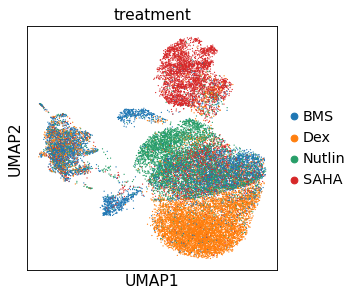

In [121]:
sc.pl.umap(sciplex2, color='treatment')

In [143]:
len(sciplex2[sciplex2.obs.dose == 0.0])

/home/yavuz/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


4047

In [141]:
len(sciplex2)

24189

/home/yavuz/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


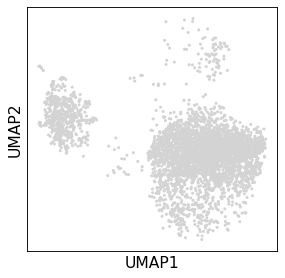

In [145]:
sc.pl.umap(sciplex2[sciplex2.obs.dose == 0.0])

In [147]:
figures_path

PosixPath('figures')

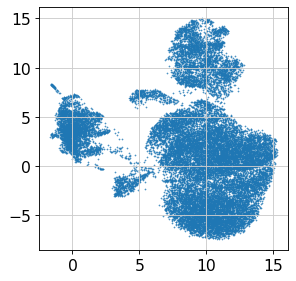

In [157]:
plt.scatter(sciplex2.obsm['X_umap'][:,0],sciplex2.obsm['X_umap'][:,1], s=0.2)

In [169]:
sciplex2.X

<24189x35915 sparse matrix of type '<class 'numpy.float32'>'
	with 60062413 stored elements in Compressed Sparse Row format>

/home/yavuz/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


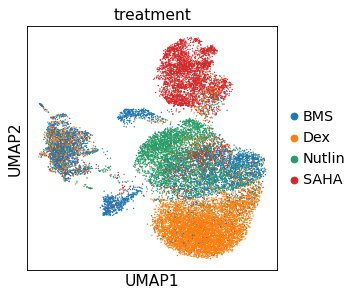

In [165]:
sc.pl.umap(sciplex2[sciplex2.obs.dose != 0.0], color='treatment', save='_by_treatment.pdf')

In [225]:
def extract_sets_from_perturbations(dataset, group_by:list=['perturbation_raw']):
    set_labels = []
    set_values = []
    for group, indices in dataset.obs.groupby(group_by).indices.items():
        set_labels.append(group)
        set_values.append(dataset[indices])
    return set_labels, set_values

import math

def pot_sinkhorn(xs, xt, reg=0.3, gpu=True):
    ws = ot.unif(len(xs))
    wt = ot.unif(len(xt))

    xs = cupy.asarray(xs)
    xt = cupy.asarray(xt)
    M = ot.gpu.dist(xs, xt, metric='euclidean', to_numpy=False)
    T = ot.gpu.sinkhorn(ws, wt, M, reg, to_numpy=False)
    return torch.as_tensor((M * T).sum(), device=device, dtype=torch.float)

def pot_emd(xs, xt):
    ws = ot.unif(len(xs))
    wt = ot.unif(len(xt))

    xs = cupy.asarray(xs)
    xt = cupy.asarray(xt)
    M = ot.gpu.dist(xs, xt, metric='euclidean', to_numpy=False)
    T = ot.gpu.to_gpu(ot.emd(ws, wt, ot.gpu.to_np(M)))
    return torch.as_tensor((M * T).sum(), device=device, dtype=torch.float)

def sinkhorn_distances_among_sets(sets, labels, sample_size=None, sample_count=None, batch_size=1, backend='geomloss', projection='umap'):
    if sample_size is not None and sample_count is not None:
        result_sets = []
        result_labels = []
        for set_idx, set in enumerate(sets):
            for i in range(sample_count):
                random_idx = np.random.randint(len(sets), size=sample_size)
                result_sets.append(set[random_idx])
                result_labels.append(labels[set_idx])
        sets = result_sets
        labels = result_labels
        data = torch.stack([torch.from_numpy(set.obsm[f'X_{projection}']).to(device) for set in sets])
        print(data.shape)
    else:
        data = np.array([torch.from_numpy(set.obsm[f'X_{projection}']).to(device) for set in sets], dtype='object')

    N = len(data)
    pairs = torch.combinations(torch.arange(N), 2)
    N_pairs = len(pairs)
    distance_matrix = torch.zeros(N,N, device=device)
    # print(N_pairs)
    # print(math.ceil(N_pairs / batch_size))
    for idx in tqdm(range(math.ceil(N_pairs / batch_size))):
        slice_ = slice(idx * batch_size, min((idx + 1) * batch_size, N_pairs))
        # batch_1 = sets[pairs[slice_, 0]].obsm['X_umap']
        # batch_2 = sets[pair[slice_, 1]].obsm['X_umap']
        batch_1 = data[pairs[slice_, 0]]
        batch_2 = data[pairs[slice_, 1]]
        if backend == 'pot':
            dist = pot_sinkhorn(batch_1, batch_2)
        if backend == 'emd':
            dist = pot_emd(batch_1, batch_2)
        elif backend == 'geomloss':
            dist = sinkhorn_geomloss(batch_1, batch_2)
        elif backend == 'cuturi':
            dist = sinkhorn_cuturi(batch_1, batch_2)[0]
        distance_matrix[pairs[slice_, 0], pairs[slice_, 1]] = dist
        distance_matrix[pairs[slice_, 1], pairs[slice_, 0]] = dist    
    return distance_matrix.cpu().numpy(), sets, labels

import umap
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def plot_embeddings_from_distance_matrix(distance_matrix, range_=None, labels=None, title=None, n_clusters=None):
    pca_ = PCA(n_components=2)
    if isinstance(distance_matrix, torch.Tensor):
        distance_matrix = distance_matrix.numpy()
    pca_.fit(distance_matrix)
    embeddings = pca_.transform(distance_matrix)
    # treat = np.array([c[0] for c in comb])
    # dose = np.array([c[1] for c in comb])
    # treat_dose = np.array([t + '_' + str(d) for t, d in zip(treat,dose)])
    # for t in np.unique(treat):
    if range_ is not None:
        embeddings = embeddings[range_,:]
        labels = labels[range_]

    if type(labels[0]) == str:
        sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], hue=labels)
    else:
        norm = colors.LogNorm()
        sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], hue=labels, hue_norm=norm, palette=sns.color_palette("flare_r", as_cmap=True))
    # sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1])
    plt.title(f'Embeddings for treatment distributions: {title}')
    plt.legend(bbox_to_anchor=(1.05,1), ncol=2)
    
    if n_clusters is not None:
        kmeans = KMeans(n_clusters=n_clusters).fit(embeddings)
        clusters = kmeans.labels_.astype(str)
        plt.figure()
        sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], hue=clusters)
        plt.title(f'Embeddings for treatment distributions: {title} (KMeans)')
        plt.legend(bbox_to_anchor=(1.05,1), ncol=2)
        return clusters
    
def add_clusters(adata, sample, n_clusters, cluster_labels):
    cluster_indices = [s.obs.index for s in sample]
    for label, index in zip(cluster_labels, cluster_indices):
        adata.obs.at[index, f'sinkhorn_cluster_{n_clusters}'] = label

In [111]:
dist, _, _ = sinkhorn_distances_among_sets(set_values, set_labels, backend='geomloss', projection='umap', sample_size=100, sample_count=30, batch_size=100)

/home/yavuz/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
100%|██████████| 46/46 [00:02<00:00, 19.15it/s]


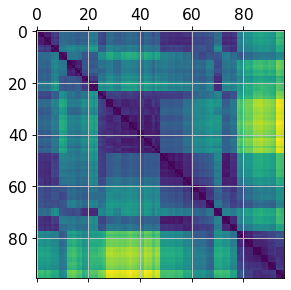

In [113]:
plt.matshow(dist)

In [109]:
t = torch.rand(400)
t2 = torch.rand(400)
print(torch.cat((t, t2)).shape)
print(torch.stack((t, t2)).shape)

torch.Size([800])
torch.Size([2, 400])


In [9]:
set_labels, set_values = extract_sets_from_perturbations(sciplex2)

/home/yavuz/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [12]:
set_values[0]

View of AnnData object with n_obs × n_vars = 1193 × 35915
    obs: 'perturbation_raw', 'cell_line', 'treatment', 'dose', 'BMS', 'Dex', 'Nutlin', 'SAHA', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes'
    var: 'gene_ids', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [26]:
set_values[0].obsp['connectivities'][0]

<1x1193 sparse matrix of type '<class 'numpy.float32'>'
	with 1 stored elements in Compressed Sparse Row format>

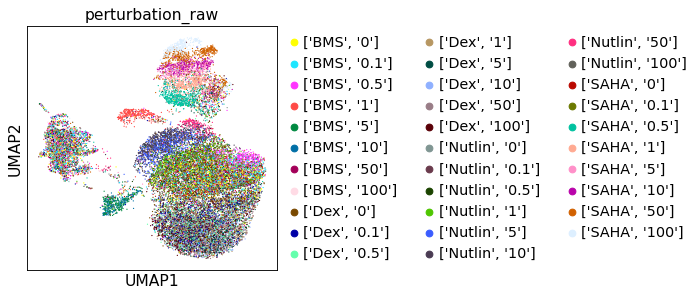

In [34]:
sc.pl.umap(sciplex2, color=['perturbation_raw'])

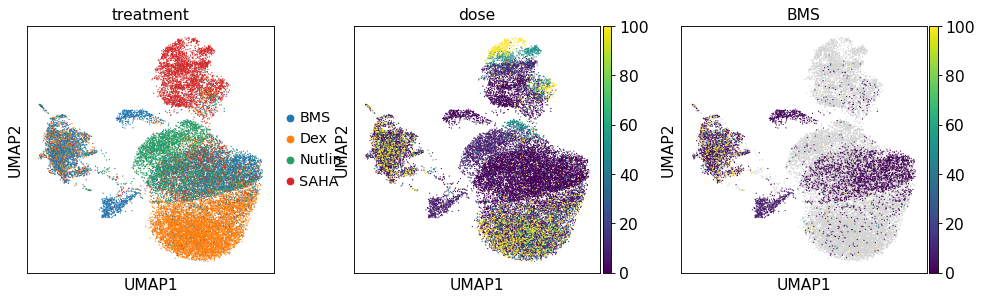

In [37]:
sc.pl.umap(sciplex2[], color=['treatment', 'dose', 'BMS'])

/home/yavuz/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


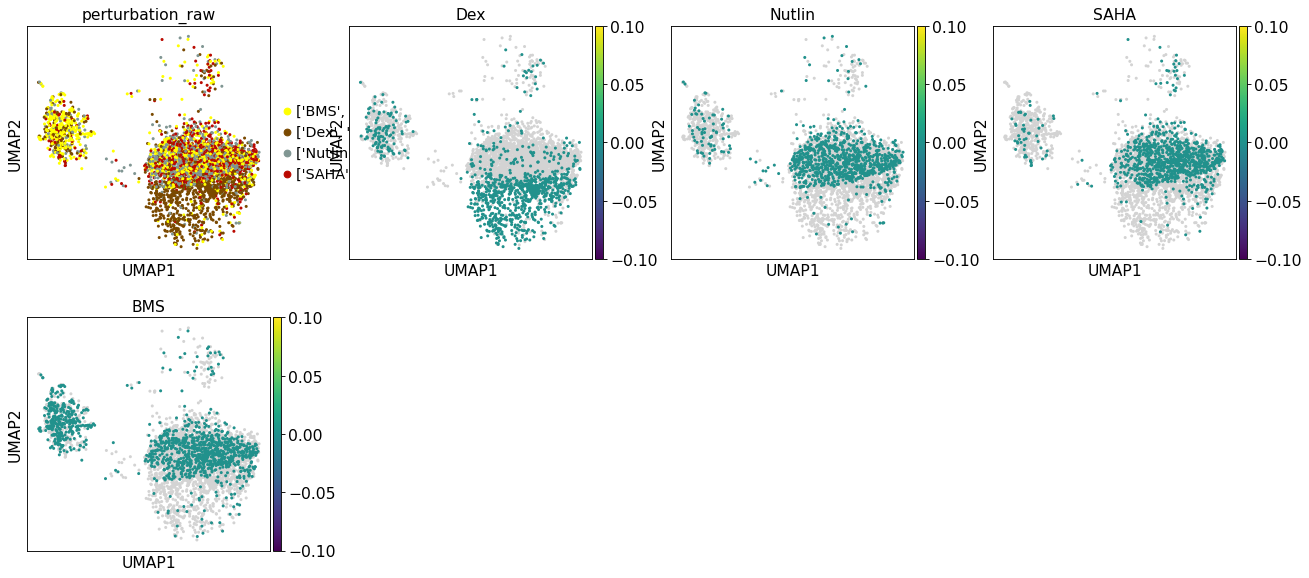

In [50]:
sc.pl.umap(sciplex2[sciplex2.obs.dose == 0.0], color=['perturbation_raw', 'Dex', 'Nutlin', 'SAHA', 'BMS'])

100%|██████████| 496/496 [00:25<00:00, 19.13it/s]


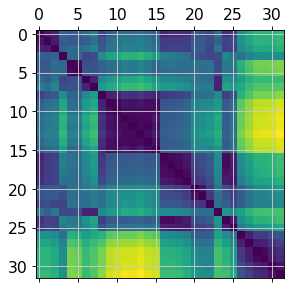

In [27]:
sinkhorn_matrix, set_values, set_labels = sinkhorn_distances_among_sets(set_values, set_labels, backend='geomloss', projection='umap')
plt.matshow(sinkhorn_matrix.cpu().numpy())

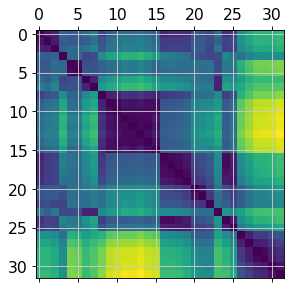

In [9]:
plt.matshow(sinkhorn_matrix)

In [171]:
labels_dose = [float(l.split("'")[3]) for l in set_labels]
labels_dose = [0.0000001 if l == 0.0 else l for l in labels_dose]

In [172]:
plot_embeddings_from_distance_matrix(distance_matrix=sinkhorn_matrix, range_=slice(0,8), labels=labels_dose, title='BMS')

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

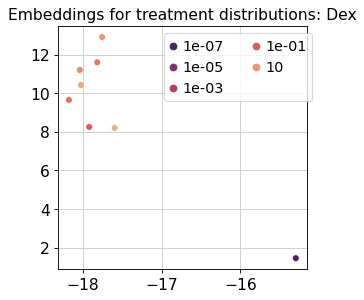

In [18]:
plot_embeddings_from_distance_matrix(distance_matrix=sinkhorn_matrix, range_=slice(8,16), labels=labels_dose, title='Dex')

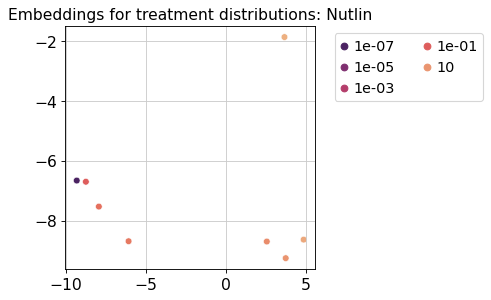

In [19]:
plot_embeddings_from_distance_matrix(distance_matrix=sinkhorn_matrix, range_=slice(16,24), labels=labels_dose, title='Nutlin')

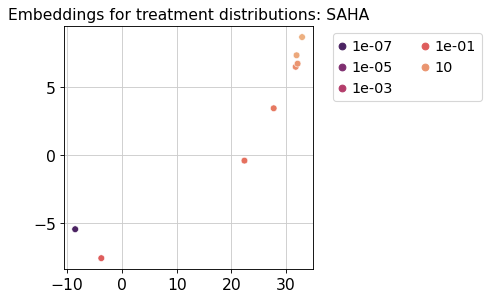

In [20]:
plot_embeddings_from_distance_matrix(distance_matrix=sinkhorn_matrix, range_=slice(24,32), labels=labels_dose, title='SAHA')

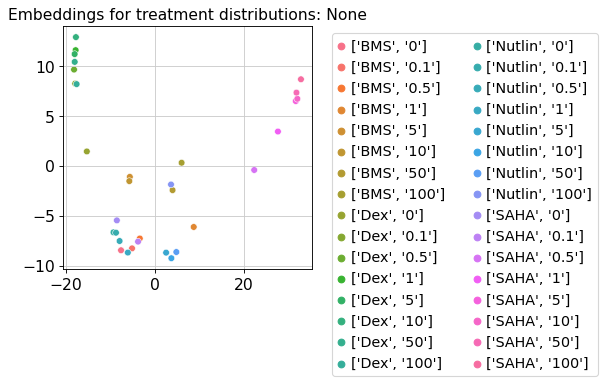

In [21]:
plot_embeddings_from_distance_matrix(distance_matrix=sinkhorn_matrix, labels=set_labels)

In [22]:
sinkhorn_matrix_size_100_sample_3, sample_sets, sample_labels = sinkhorn_distances_among_sets(set_values, set_labels, sample_size=100, sample_count=3)

/home/yavuz/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
100%|██████████| 4560/4560 [04:26<00:00, 17.12it/s]


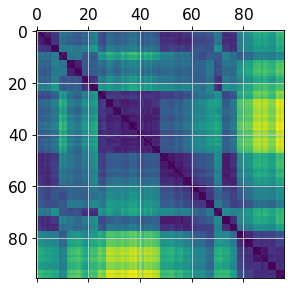

In [23]:
plt.matshow(sinkhorn_matrix_size_100_sample_3)

In [25]:
sample_labels_dose = [float(l.split("'")[3]) for l in sample_labels]
sample_labels_dose = [0.0000001 if l == 0.0 else l for l in sample_labels_dose]

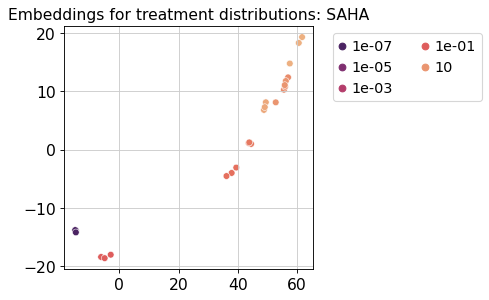

In [26]:

plot_embeddings_from_distance_matrix(distance_matrix=sinkhorn_matrix_size_100_sample_3, range_=slice(72,96), labels=sample_labels_dose, title='SAHA')

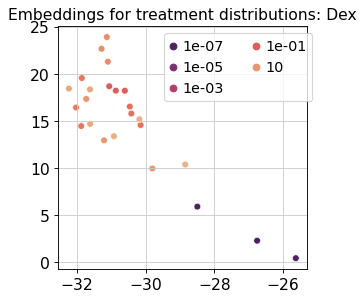

In [27]:
plot_embeddings_from_distance_matrix(distance_matrix=sinkhorn_matrix_size_100_sample_3, range_=slice(24,48), labels=sample_labels_dose, title='Dex')

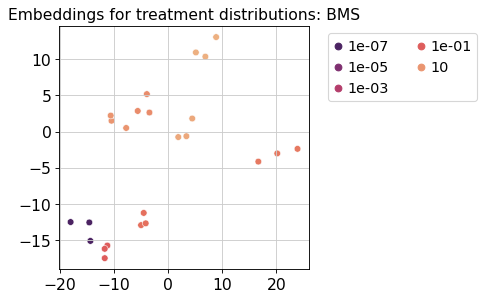

In [28]:
plot_embeddings_from_distance_matrix(distance_matrix=sinkhorn_matrix_size_100_sample_3, range_=slice(0,24), labels=sample_labels_dose, title='BMS')

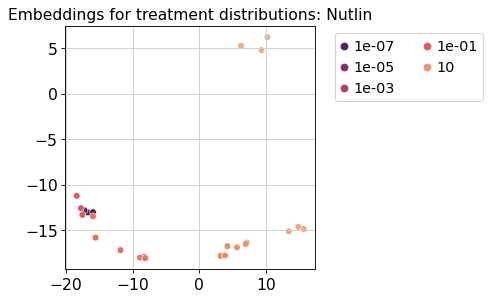

In [29]:
plot_embeddings_from_distance_matrix(distance_matrix=sinkhorn_matrix_size_100_sample_3, range_=slice(48,72), labels=sample_labels_dose, title='Nutlin')

## Clustering in embedding space

In [30]:
sc.tl.leiden(sciplex2)

running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:18)


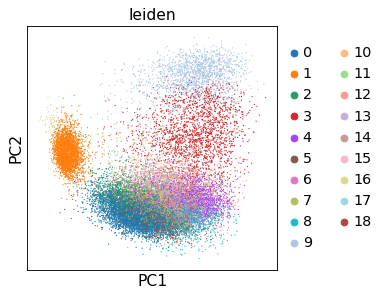

In [31]:
sc.pl.pca(sciplex2, color='leiden')

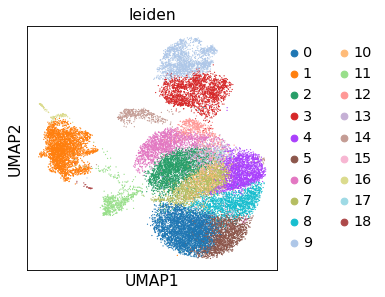

In [32]:
sc.pl.umap(sciplex2, color='leiden')

In [ ]:
len(cluster_labels)

In [33]:
cluster_indices = [s.obs.index for s in sample_sets]

In [ ]:
len(cluster_indices)

In [34]:
sciplex2.obs['sinkhorn_cluster'] = '-1'

In [35]:
sciplex2.obs['sinkhorn_cluster'].unique()

array(['-1'], dtype=object)

In [36]:
for label, index in zip(kmeans_clusters_18, cluster_indices):
    sciplex2.obs.at[index, 'sinkhorn_cluster_18'] = label

NameError: name 'cluster_labels' is not defined

In [ ]:
sciplex2.obs['sinkhorn_cluster']

In [ ]:
(sciplex2.obs['sinkhorn_cluster'] != '-1').value_counts()

In [ ]:
sc.pl.umap(sciplex2[sciplex2.obs['sinkhorn_cluster'] != '-1'], color=['sinkhorn_cluster'])

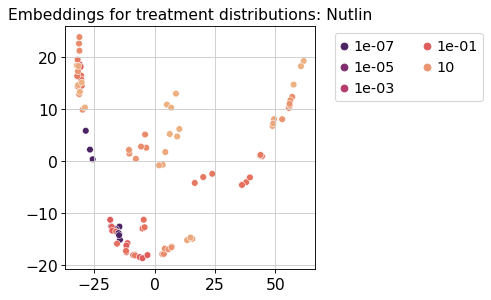

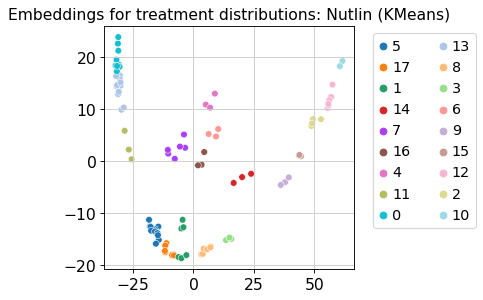

In [80]:
kmeans_clusters_18 = plot_embeddings_from_distance_matrix(distance_matrix=sinkhorn_matrix_size_100_sample_3, labels=sample_labels_dose, title='Nutlin', n_clusters=18)

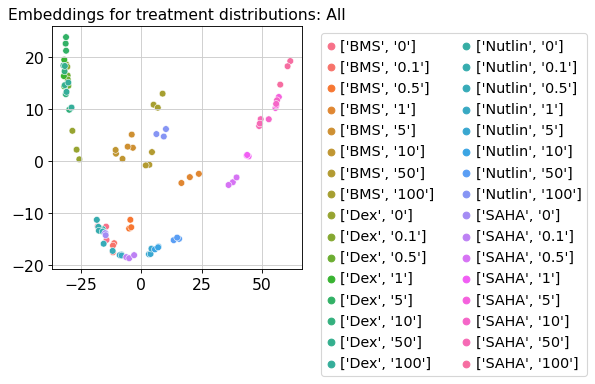

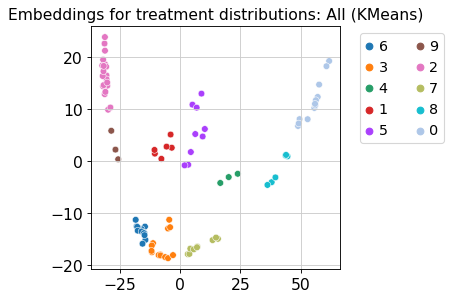

In [65]:
kmeans_clusters_10 = plot_embeddings_from_distance_matrix(distance_matrix=sinkhorn_matrix_size_100_sample_3, labels=sample_labels, title='All', n_clusters=10)

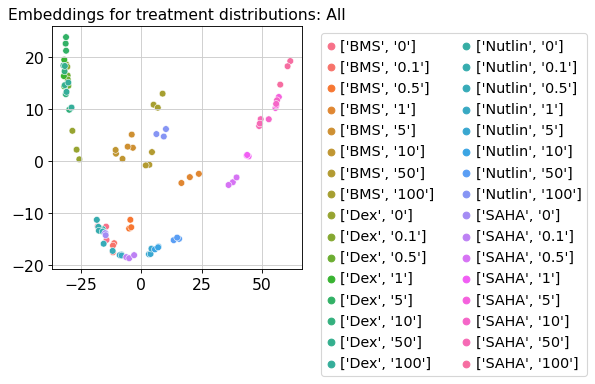

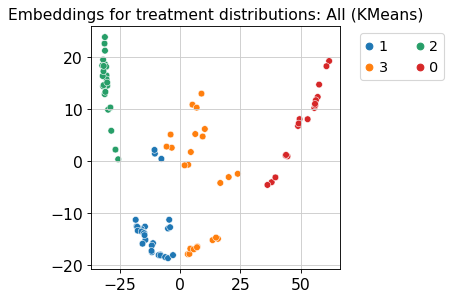

In [66]:
kmeans_clusters_4 = plot_embeddings_from_distance_matrix(distance_matrix=sinkhorn_matrix_size_100_sample_3, labels=sample_labels, title='All', n_clusters=4)

In [44]:
sciplex2

AnnData object with n_obs × n_vars = 24189 × 35915
    obs: 'perturbation_raw', 'cell_line', 'treatment', 'dose', 'BMS', 'Dex', 'Nutlin', 'SAHA', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes', 'leiden', 'sinkhorn_cluster'
    var: 'gene_ids', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'neighbors', 'pca', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [45]:
add_clusters(sciplex2, sample_sets, 18, kmeans_clusters_18)

In [46]:
sciplex2

AnnData object with n_obs × n_vars = 24189 × 35915
    obs: 'perturbation_raw', 'cell_line', 'treatment', 'dose', 'BMS', 'Dex', 'Nutlin', 'SAHA', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes', 'leiden', 'sinkhorn_cluster', 'sinkhorn_cluster_18'
    var: 'gene_ids', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'neighbors', 'pca', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

... storing 'sinkhorn_cluster_10' as categorical


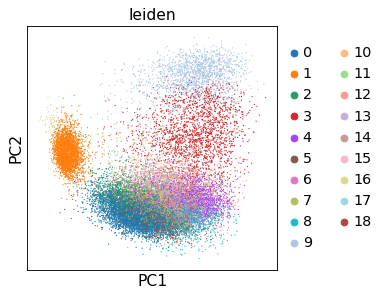

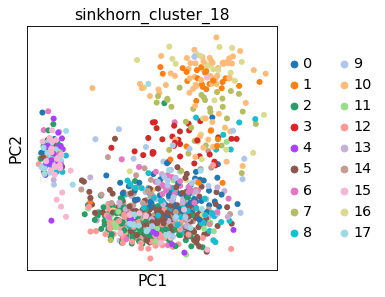

In [77]:
sc.pl.pca(sciplex2, color='leiden')
sc.pl.pca(sciplex2[sciplex2.obs['sinkhorn_cluster_18'] != 'nan'], color='sinkhorn_cluster_18')

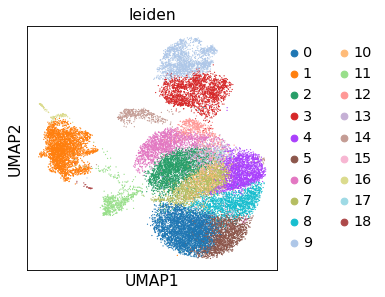

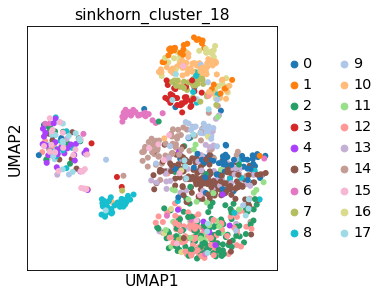

In [78]:
sc.pl.umap(sciplex2, color='leiden')
sc.pl.umap(sciplex2[sciplex2.obs['sinkhorn_cluster_18'] != 'nan'], color='sinkhorn_cluster_18')

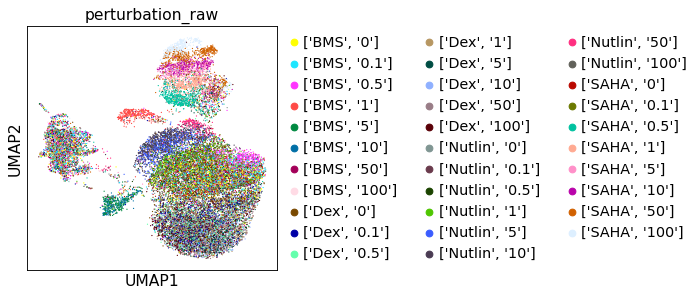

In [87]:
sc.pl.umap(sciplex2, color=['perturbation_raw'])

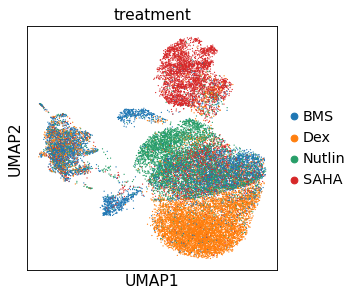

In [82]:
sc.pl.umap(sciplex2, color='treatment')

In [ ]:
sciplex2.obs()

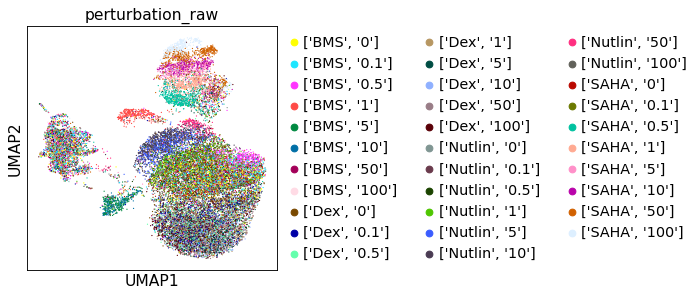

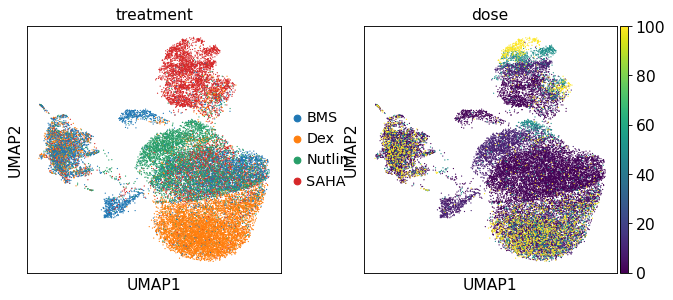

In [84]:

sc.pl.umap(sciplex2, color=['treatment','dose'])

In [81]:
sciplex2

AnnData object with n_obs × n_vars = 24189 × 35915
    obs: 'perturbation_raw', 'cell_line', 'treatment', 'dose', 'BMS', 'Dex', 'Nutlin', 'SAHA', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes', 'leiden', 'sinkhorn_cluster', 'sinkhorn_cluster_18', 'sinkhorn_cluster_10'
    var: 'gene_ids', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'neighbors', 'pca', 'umap', 'leiden', 'leiden_colors', 'sinkhorn_cluster_18_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [67]:
add_clusters(sciplex2, sample_sets, 10, kmeans_clusters_10)

In [60]:
sinkhorn_matrix_size_100_sample_10, sample_sets_10, sample_labels_10 = sinkhorn_distances_among_sets(set_values, set_labels, sample_size=100, sample_count=10)

  0%|          | 0/511 [00:00<?, ?it/s]


TypeError: only integer tensors of a single element can be converted to an index

In [105]:
sahaasample_labels.index("['Dex', '10']")

39

In [106]:
sample_labels.index("['SAHA', '100']")

93

In [ ]:
"['SAHA', '100']"

In [109]:
dex_10

View of AnnData object with n_obs × n_vars = 100 × 35915
    obs: 'perturbation_raw', 'cell_line', 'treatment', 'dose', 'BMS', 'Dex', 'Nutlin', 'SAHA', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes'
    var: 'gene_ids', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
dex_10.X_pca()

In [112]:
dex_10.obsm['X_pca'].value()

AttributeError: 'ArrayView' object has no attribute 'value'

In [118]:
dex_10_vs_saha_100 = sinkhorn_cuturi(torch.from_numpy(dex_10.obsm['X_pca']), torch.from_numpy(saha_100.obsm['X_pca']))

In [119]:
dex_10_vs_saha_100

(tensor(168.0833),
 tensor([[6.0991e-37, 1.0173e-30, 0.0000e+00,  ..., 1.9977e-03, 0.0000e+00,
          0.0000e+00],
         [4.5861e-26, 0.0000e+00, 0.0000e+00,  ..., 1.3865e-19, 0.0000e+00,
          0.0000e+00],
         [1.0744e-29, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         ...,
         [0.0000e+00, 2.0000e-03, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [2.5798e-42, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 4.2039e-45, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00]]),
 tensor([[175.5598, 163.9262, 226.1122,  ..., 208.7227, 220.6382, 226.1122],
         [166.5353, 169.6173, 220.1689,  ..., 205.9231, 209.8216, 220.1689],
         [172.7467, 171.6732, 222.3658,  ..., 220.8990, 221.2407, 222.3658],
         ...,
         [148.4362, 128.0094, 212.1004,  ..., 206.6210, 210.0293, 212.1004],
         [178.9240, 184.7405, 230.6270,  ..., 227

dex_10_vs_saha_100[1].shape

In [128]:
dex_10_vs_saha_100[1].max()

tensor(0.0090)

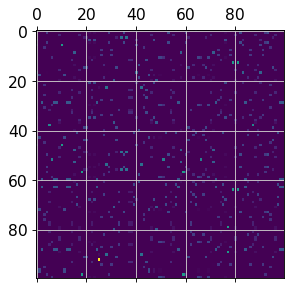

In [121]:
plt.matshow(dex_10_vs_saha_100[1])

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
... storing 'perturbation_raw' as categorical
... storing 'treatment' as categorical


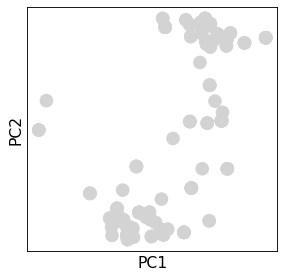

In [151]:
sc.pl.pca(sc.concat([dex_10,saha_100]))

<ipython-input-178-2999d596d700>:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(figures_path / 'transport_weights.pdf')
<ipython-input-178-2999d596d700>:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(figures_path / 'transport_weights.pdf')
/home/yavuz/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


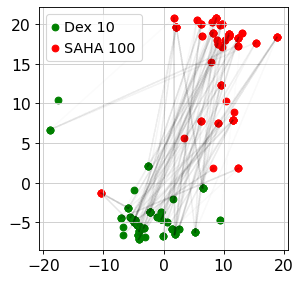

In [178]:
plt.scatter(dex_10.obsm['X_pca'][:,0], dex_10.obsm['X_pca'][:,1], c='g', label='Dex 10')
plt.scatter(saha_100.obsm['X_pca'][:,0], saha_100.obsm['X_pca'][:,1], c='r', label='SAHA 100')
for i in range(len(dex_10.obsm['X_pca'])):
    for j in range(i+1, len(dex_10.obsm['X_pca'])):
        transport_weight = dex_10_vs_saha_100[1][i,j].numpy().item()
        if  transport_weight != 0.0:
    #         plt.plot(dex_10.obsm['X_pca'][i,0], saha_100.obsm['X_pca'][i,1], alpha = transport_weight)
            plt.plot([dex_10.obsm['X_pca'][i,0], saha_100.obsm['X_pca'][i,0]], [dex_10.obsm['X_pca'][i,1], saha_100.obsm['X_pca'][i,1]], alpha=transport_weight * 10, c='black')
plt.legend(loc=)
plt.savefig(figures_path / 'transport_weights.pdf')

In [140]:
dex_10_vs_saha_100[1][0,0].numpy().item()

6.099115916940834e-37

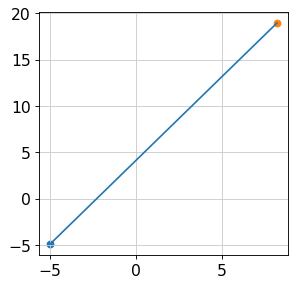

In [159]:
plt.scatter(dex_10.obsm['X_pca'][0,0], dex_10.obsm['X_pca'][0,1])
plt.scatter(saha_100.obsm['X_pca'][0,0], saha_100.obsm['X_pca'][0,1])
plt.plot([dex_10.obsm['X_pca'][0,0], saha_100.obsm['X_pca'][0,0]], [dex_10.obsm['X_pca'][0,1], saha_100.obsm['X_pca'][0,1]])

In [154]:
dex_10.obsm['X_pca'][0,0:2]

ArrayView([-4.984095 , -4.9219193], dtype=float32)

In [254]:
torch.from_numpy(pert2_data.obsm['X_pca'])

NameError: name 'pert2_data' is not defined

tensor(5.6797)
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])
tensor([0.0324, 0.0337, 0.0349, 0.0341, 0.0304, 0.0346, 0.0340, 0.0333, 0.0343,
        0.0333, 0.0328, 0.0343, 0.0329, 0.0346, 0.0337, 0.0341, 0.0337, 0.0325,
        0.0304, 0.0304, 0.0331, 0.0323, 0.0336, 0.0349, 0.0341, 0.0346, 0.0342,
        0.0341, 0.0323, 0.0326])
tensor(1.0000)


<ipython-input-301-34e4780b994c>:24: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.scatter(rand1[:,0], rand1[:,1], c=result[1].sum(dim=1), vmin=0.0001, vmax=1, cmap='summer', norm=norm)
<ipython-input-301-34e4780b994c>:25: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.scatter(rand2[:,0], rand2[:,1], c=result[1].sum(dim=0), vmin=0.0001, vmax=1, cmap='autumn', norm=norm)


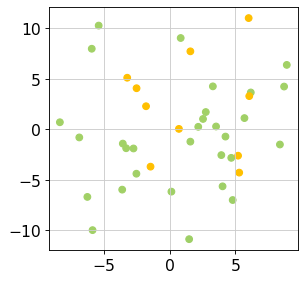

In [301]:
def dummy():
    pert1 = "['Dex', '10']"
    pert2 = "['SAHA', '10']"
    pert1_data = sample_sets[sample_labels.index(pert1)]
    pert2_data = sample_sets[sample_labels.index(pert2)]
#     print(torch.from_numpy(pert2_data.obsm['X_pca']).shape)
    sinkhorn_result = sinkhorn_cuturi(torch.from_numpy(pert1_data.obsm['X_pca'][:10]), torch.from_numpy(pert2_data.obsm['X_pca']))
    sinkhorn_result2 = sinkhorn_cuturi(torch.from_numpy(pert2_data.obsm['X_pca']), torch.from_numpy(pert1_data.obsm['X_pca']))
#     print(sinkhorn_result[1].sum())
#     print(sinkhorn_result[1].sum(dim=0))
#     print(sinkhorn_result[1].sum(dim=1))
#     print(sinkhorn_result2[1].sum())
#     print(sinkhorn_result2[1].sum(dim=0))
#     print(sinkhorn_result2[1].sum(dim=1))
    
    rand1 = torch.randn(30,2) * 5
    rand2 = torch.cat([torch.randn(10,2) * 5])
    result = sinkhorn_cuturi(rand1, rand2)
    print(result[0])
    print(result[1].sum(dim=0))
    print(result[1].sum(dim=1))
    print(result[1].sum())
    norm = colors.LogNorm()
    plt.scatter(rand1[:,0], rand1[:,1], c=result[1].sum(dim=1), vmin=0.0001, vmax=1, cmap='summer', norm=norm)
    plt.scatter(rand2[:,0], rand2[:,1], c=result[1].sum(dim=0), vmin=0.0001, vmax=1, cmap='autumn', norm=norm)

dummy()

In [312]:
def compare_perturbations(pert1, pert2):
    pert1_data = sample_sets[sample_labels.index(pert1)]
    pert2_data = sample_sets[sample_labels.index(pert2)]
    sinkhorn_result = sinkhorn_cuturi(torch.from_numpy(pert1_data.obsm['X_pca']), torch.from_numpy(pert2_data.obsm['X_pca']))
    sns.heatmap(sinkhorn_result[1], label='Transport Plan')
    transport_weights = sinkhorn_result[1].sum(dim=1)
    plt.figure()
    sns.scatterplot(x=pert1_data.obsm['X_pca'][:,0], y=pert1_data.obsm['X_pca'][:,1], hue=transport_weights, label=pert1, palette='autumn')
    sns.scatterplot(x=pert2_data.obsm['X_pca'][:,0], y=pert2_data.obsm['X_pca'][:,1], label=pert2, c='blue')
    
#     plt.scatter(pert2_data.obsm['X_pca'][:,0], pert2_data.obsm['X_pca'][:,1], c=transport_weights_pert2, label=pert2, cmap='autumn')
    for i in range(len(pert1_data.obsm['X_pca'])):
        for j in range(i+1, len(pert1_data.obsm['X_pca'])):
            transport_weight = sinkhorn_result[1][i,j].numpy().item()
            if  transport_weight != 0.0:
                
        #         plt.plot(dex_10.obsm['X_pca'][i,0], saha_100.obsm['X_pca'][i,1], alpha = transport_weight)
                plt.plot([pert1_data.obsm['X_pca'][i,0], pert2_data.obsm['X_pca'][i,0]], [pert1_data.obsm['X_pca'][i,1], pert2_data.obsm['X_pca'][i,1]], alpha=transport_weight * 10, c='black')
    plt.legend(loc='upper right', bbox_to_anchor=(1.5,1.0)) 
    plt.savefig(figures_path / f'transport_weights_{pert1}_{pert2}.pdf')

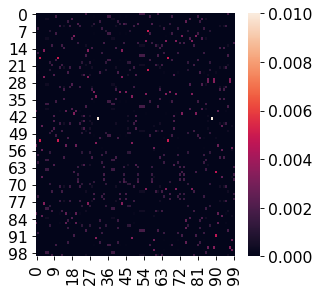

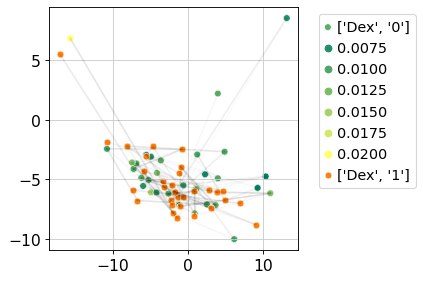

In [305]:
compare_perturbations("['Dex', '0']", "['Dex', '1']")

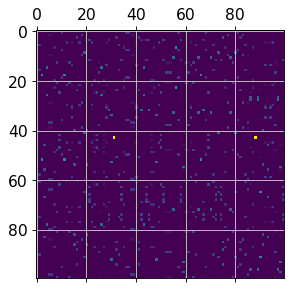

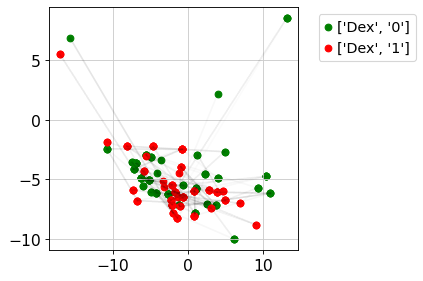

In [195]:
compare_perturbations("['Dex', '0']", "['Dex', '1']")

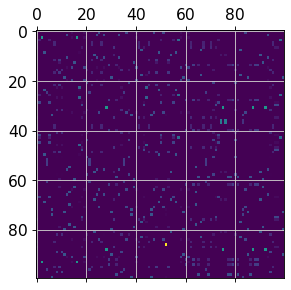

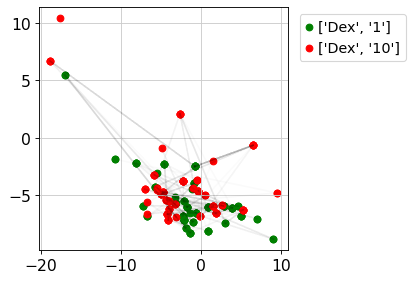

In [196]:
compare_perturbations("['Dex', '1']", "['Dex', '10']")

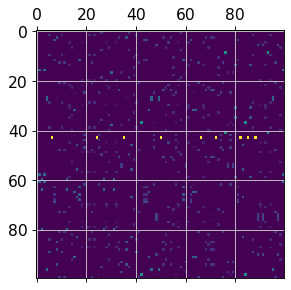

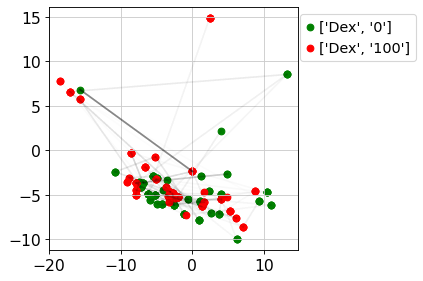

In [197]:
compare_perturbations("['Dex', '0']", "['Dex', '100']")

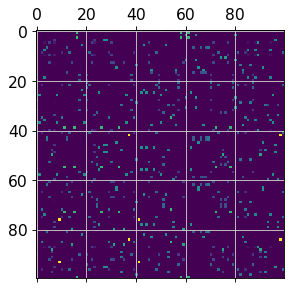

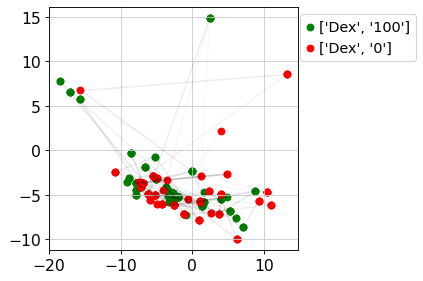

In [198]:
compare_perturbations("['Dex', '100']", "['Dex', '0']")

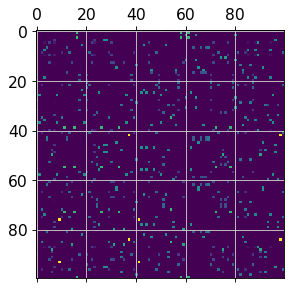

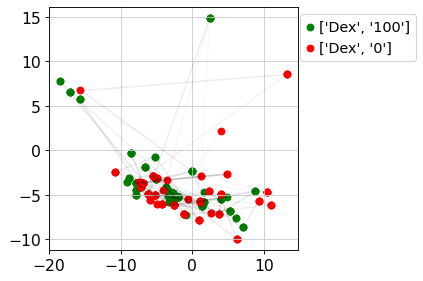

In [199]:
compare_perturbations("['Dex', '100']", "['Dex', '0']")

In [203]:
sinkhorn_cuturi(torch.from_numpy(dex_10.obsm['X_pca']), torch.from_numpy(saha_100.obsm['X_pca']))

(tensor(168.0833),
 tensor([[6.0991e-37, 1.0173e-30, 0.0000e+00,  ..., 1.9977e-03, 0.0000e+00,
          0.0000e+00],
         [4.5861e-26, 0.0000e+00, 0.0000e+00,  ..., 1.3865e-19, 0.0000e+00,
          0.0000e+00],
         [1.0744e-29, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         ...,
         [0.0000e+00, 2.0000e-03, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [2.5798e-42, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 4.2039e-45, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00]]),
 tensor([[175.5598, 163.9262, 226.1122,  ..., 208.7227, 220.6382, 226.1122],
         [166.5353, 169.6173, 220.1689,  ..., 205.9231, 209.8216, 220.1689],
         [172.7467, 171.6732, 222.3658,  ..., 220.8990, 221.2407, 222.3658],
         ...,
         [148.4362, 128.0094, 212.1004,  ..., 206.6210, 210.0293, 212.1004],
         [178.9240, 184.7405, 230.6270,  ..., 227

In [204]:
sinkhorn_cuturi(torch.from_numpy(saha_100.obsm['X_pca']), torch.from_numpy(dex_10.obsm['X_pca']))

(tensor(169.0096),
 tensor([[0.0000e+00, 0.0000e+00, 7.2406e-21,  ..., 4.3721e-36, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.5330e-03, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 0.0000e+00, 3.8995e-13,  ..., 0.0000e+00, 0.0000e+00,
          2.9760e-39],
         ...,
         [2.4999e-03, 1.1384e-33, 1.4719e-27,  ..., 0.0000e+00, 0.0000e+00,
          3.2090e-43],
         [0.0000e+00, 0.0000e+00, 1.0632e-37,  ..., 0.0000e+00, 0.0000e+00,
          1.7647e-22],
         [0.0000e+00, 0.0000e+00, 3.8995e-13,  ..., 0.0000e+00, 0.0000e+00,
          2.9760e-39]]),
 tensor([[175.5598, 166.5353, 172.7467,  ..., 148.4362, 178.9240, 179.2989],
         [163.9262, 169.6173, 171.6732,  ..., 128.0094, 184.7405, 165.8217],
         [226.1122, 220.1689, 222.3658,  ..., 212.1004, 230.6270, 228.4297],
         ...,
         [208.7227, 205.9231, 220.8990,  ..., 206.6210, 227.7790, 224.5554],
         [220.6382, 209.8216, 221.2407,  ..., 210

In [ ]:
sinkhorn_cuturi

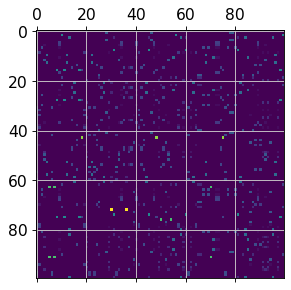

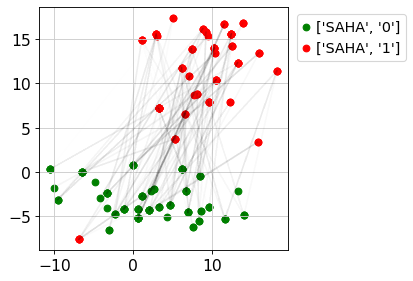

In [205]:
compare_perturbations("['SAHA', '0']", "['SAHA', '1']")

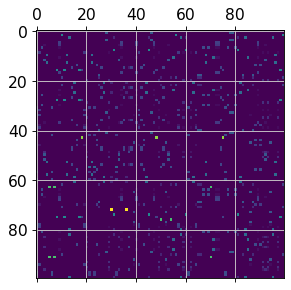

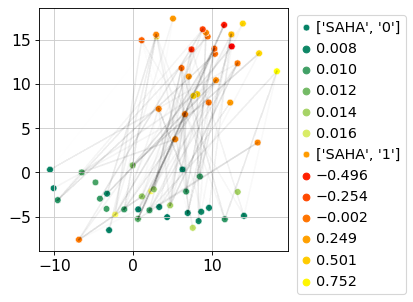

In [224]:
compare_perturbations("['SAHA', '0']", "['SAHA', '1']")

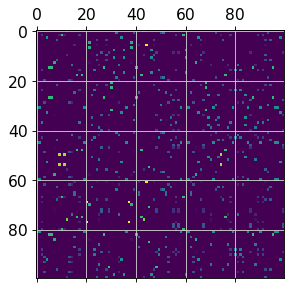

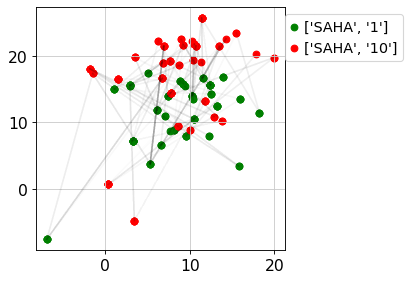

In [206]:
compare_perturbations("['SAHA', '1']", "['SAHA', '10']")

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not blue

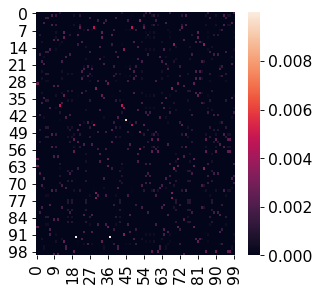

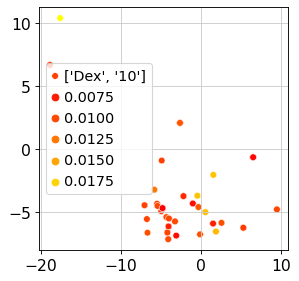

In [313]:
compare_perturbations("['Dex', '10']", "['SAHA', '10']")

In [315]:
!pip install pot

     |████████████████████████████████| 455 kB 7.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 13.3 MB/s eta 0:00:01


In [316]:
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot

In [343]:
n = 30  # nb samples
m = 20
mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(m, mu_t, cov_t)

a, b = np.ones((n,)) / n, np.ones((m,)) / m  # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)
M /= M.max()

Text(0.5, 1.0, 'Cost matrix M')

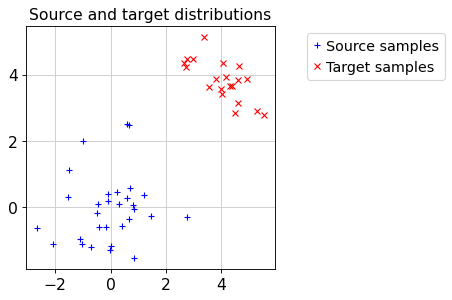

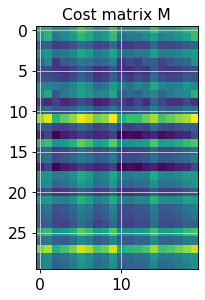

In [344]:
pl.figure(1)
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.legend(bbox_to_anchor=(1.1,1))
pl.title('Source and target distributions')

pl.figure(2)
pl.imshow(M, interpolation='nearest')
pl.title('Cost matrix M')

In [336]:
G0.shape

(50, 10)

In [328]:
type(G0)

numpy.ndarray

In [339]:
np.sum(G0, axis=1)

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [338]:
np.sum(G0, axis=0)

array([0.25, 0.25, 0.25, 0.25])

Text(0.5, 1.0, 'OT matrix with samples')

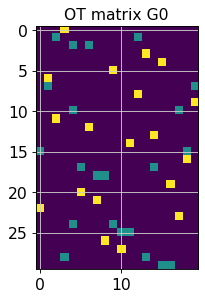

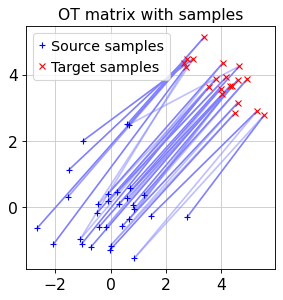

In [345]:
G0 = ot.emd(a, b, M)

pl.figure(3)
pl.imshow(G0, interpolation='nearest')
pl.title('OT matrix G0')

pl.figure(4)
ot.plot.plot2D_samples_mat(xs, xt, G0, c=[.5, .5, 1])
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('OT matrix with samples')

Text(0.5, 1.0, 'OT matrix with samples')

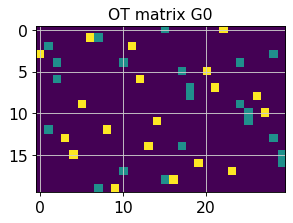

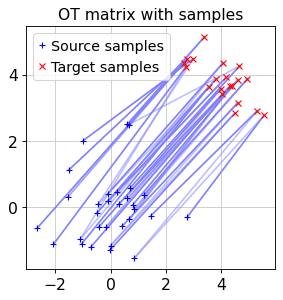

In [353]:
G1 = ot.emd(b, a, np.ascontiguousarray(M.T))

pl.figure(3)
pl.imshow(G1, interpolation='nearest')
pl.title('OT matrix G0')

pl.figure(4)
ot.plot.plot2D_samples_mat(xt, xs, G1, c=[.5, .5, 1])
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('OT matrix with samples')

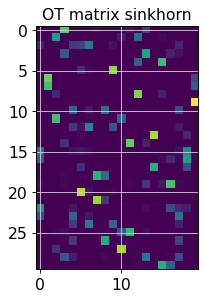

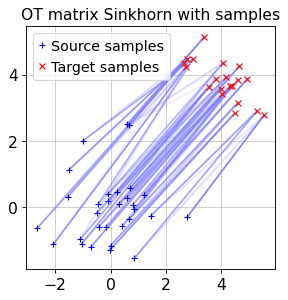

In [346]:
# reg term
lambd = 1e-3

Gs = ot.sinkhorn(a, b, M, lambd)

pl.figure(5)
pl.imshow(Gs, interpolation='nearest')
pl.title('OT matrix sinkhorn')

pl.figure(6)
ot.plot.plot2D_samples_mat(xs, xt, Gs, color=[.5, .5, 1])
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('OT matrix Sinkhorn with samples')

pl.show()

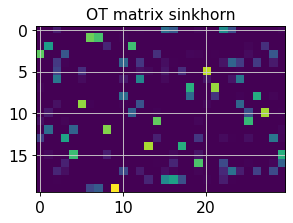

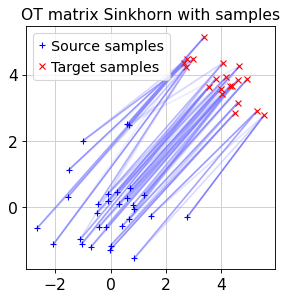

In [354]:
# reg term
lambd = 1e-3

Gst = ot.sinkhorn(b, a, np.ascontiguousarray(M.T), lambd)

pl.figure(5)
pl.imshow(Gst, interpolation='nearest')
pl.title('OT matrix sinkhorn')

pl.figure(6)
ot.plot.plot2D_samples_mat(xt, xs, Gst, color=[.5, .5, 1])
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('OT matrix Sinkhorn with samples') 

pl.show()

In [359]:
Gst[10,0]

4.159153034738829e-09

Text(0.5, 1.0, 'OT matrix with samples')

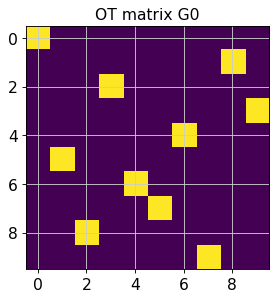

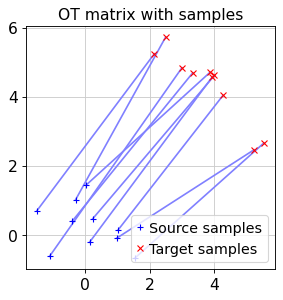

In [374]:
n = 10  # nb samples
m = 10
mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(m, mu_t, cov_t)

a, b = np.ones((n,)) / n, np.ones((m,)) / m  # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)
M /= M.max()

G0 = ot.emd(a, b, M)

pl.figure(3)
pl.imshow(G0, interpolation='nearest')
pl.title('OT matrix G0')

pl.figure(4)
ot.plot.plot2D_samples_mat(xs, xt, G0, c=[.5, .5, 1])
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('OT matrix with samples')

In [375]:
print(G0)

[[0.1 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.1 0. ]
 [0.  0.  0.  0.1 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1]
 [0.  0.  0.  0.  0.  0.  0.1 0.  0.  0. ]
 [0.  0.1 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.1 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.1 0.  0.  0.  0. ]
 [0.  0.  0.1 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.1 0.  0. ]]


In [362]:
print(G0.shape)
print(G0.sum())
print(G0.sum(axis=0))
print(G0.sum(axis=1))

(5, 10)
1.0
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0.2 0.2 0.2 0.2 0.2]


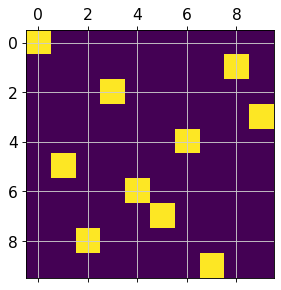

In [376]:
plt.matshow(G0)

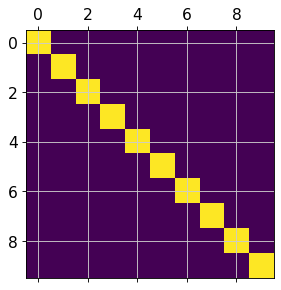

In [377]:
plt.matshow(G0 @ G0.T)

In [371]:
G0

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0.1],
       [0. , 0.1, 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.1, 0. , 0. , 0.1, 0. , 0. , 0. , 0. ],
       [0.1, 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0.1, 0. , 0. ]])

In [370]:
G0 @ G0.T

array([[0.02, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.02, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.02, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.02, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.02]])

In [379]:
G0.T @ G0

array([[0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01]])

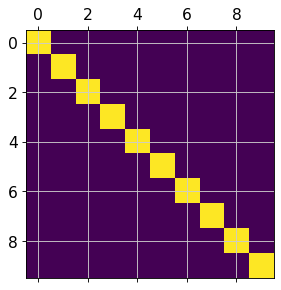

In [378]:
plt.matshow(G0.T @ G0)

Text(0.5, 1.0, 'OT matrix with samples')

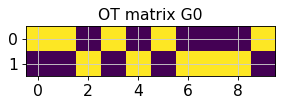

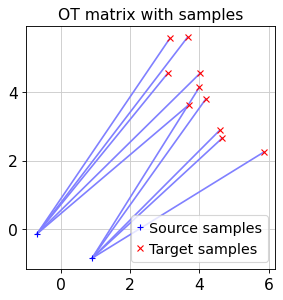

In [380]:
n = 2  # nb samples
m = 10
mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(m, mu_t, cov_t)

a, b = np.ones((n,)) / n, np.ones((m,)) / m  # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)
M /= M.max()

G0 = ot.emd(a, b, M)

pl.figure(3)
pl.imshow(G0, interpolation='nearest')
pl.title('OT matrix G0')

pl.figure(4)
ot.plot.plot2D_samples_mat(xs, xt, G0, c=[.5, .5, 1])
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('OT matrix with samples')

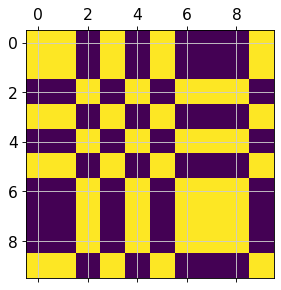

In [381]:
plt.matshow(G0.T @ G0)

In [389]:
G0[0,:]

array([1.00000000e-01, 1.00000000e-01, 0.00000000e+00, 1.00000000e-01,
       0.00000000e+00, 1.00000000e-01, 0.00000000e+00, 0.00000000e+00,
       2.77555756e-17, 1.00000000e-01])

In [384]:
G0.T @ G0

array([[1.00000000e-02, 1.00000000e-02, 0.00000000e+00, 1.00000000e-02,
        0.00000000e+00, 1.00000000e-02, 0.00000000e+00, 0.00000000e+00,
        2.77555756e-18, 1.00000000e-02],
       [1.00000000e-02, 1.00000000e-02, 0.00000000e+00, 1.00000000e-02,
        0.00000000e+00, 1.00000000e-02, 0.00000000e+00, 0.00000000e+00,
        2.77555756e-18, 1.00000000e-02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e-02, 0.00000000e+00,
        1.00000000e-02, 0.00000000e+00, 1.00000000e-02, 1.00000000e-02,
        1.00000000e-02, 0.00000000e+00],
       [1.00000000e-02, 1.00000000e-02, 0.00000000e+00, 1.00000000e-02,
        0.00000000e+00, 1.00000000e-02, 0.00000000e+00, 0.00000000e+00,
        2.77555756e-18, 1.00000000e-02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e-02, 0.00000000e+00,
        1.00000000e-02, 0.00000000e+00, 1.00000000e-02, 1.00000000e-02,
        1.00000000e-02, 0.00000000e+00],
       [1.00000000e-02, 1.00000000e-02, 0.00000000e+00, 1.00000000e-02,
   

In [383]:
G0 @ G0.T

array([[5.00000000e-02, 2.77555756e-18],
       [2.77555756e-18, 5.00000000e-02]])

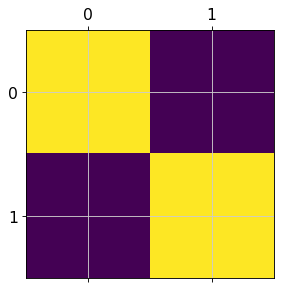

In [382]:
plt.matshow(G0 @ G0.T)

# Regression in Perturbation Encoding Space

## Using full distributions

In [177]:
distance_matrix, set_values, set_labels = sinkhorn_distances_among_sets(set_values, set_labels, backend='geomloss', projection='umap')

100%|██████████| 496/496 [00:24<00:00, 19.84it/s]


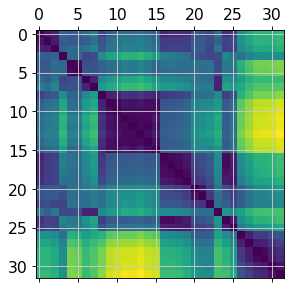

In [178]:
plt.matshow(distance_matrix)

In [54]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, n_jobs=-1, dissimilarity='precomputed')
perturb_embeddings = mds.fit_transform(distance_matrix)

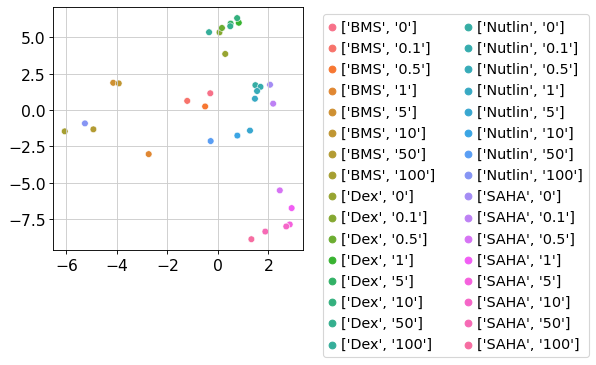

In [63]:
sns.scatterplot(x=perturb_embeddings[:,0], y=perturb_embeddings[:,1], hue=set_labels)
plt.legend(bbox_to_anchor=(1.05,1), ncol=2)


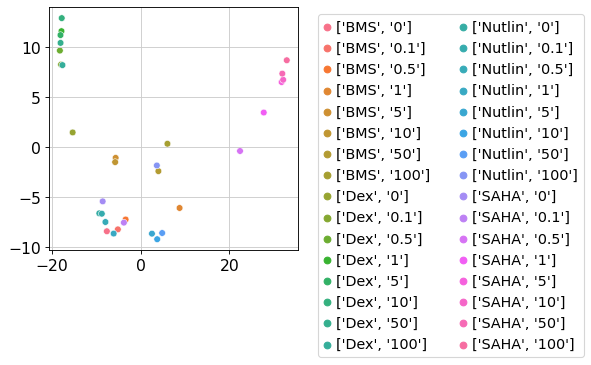

In [61]:
pca = PCA(n_components=2)
perturb_embeddings_pca = pca.fit_transform(distance_matrix)
sns.scatterplot(x=perturb_embeddings_pca[:,0], y=perturb_embeddings_pca[:,1], hue=set_labels)
plt.legend(bbox_to_anchor=(1.05,1), ncol=2)

# plt.scatter(, perturb_embeddings_pca[:,1], )

# Using samples from distributions

In [10]:
distance_matrix_sample_200_30, set_values_sample_200_30, set_labels_sample_200_30 = sinkhorn_distances_among_sets(set_values, set_labels, backend='geomloss', projection='umap', sample_size=200, sample_count=30, batch_size=200)
plt.matshow(distance_matrix)

  0%|          | 0/2302 [00:00<?, ?it/s]

torch.Size([960, 200, 2])


100%|██████████| 2302/2302 [06:09<00:00,  6.23it/s]


NameError: name 'distance_matrix' is not defined

In [123]:
# set_labels_sample_200_30 = [ l if  "'0'" not in l else 'Default' for l in set_labels_sample_200_30]

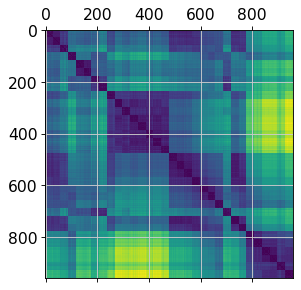

In [11]:
plt.matshow(distance_matrix_sample_200_30)

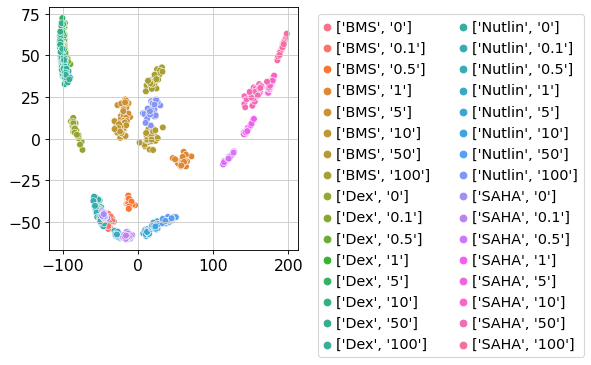

In [12]:
pca = PCA(n_components=2)
perturb_embeddings_pca = pca.fit_transform(distance_matrix_sample_200_30)
sns.scatterplot(x=perturb_embeddings_pca[:,0], y=perturb_embeddings_pca[:,1], hue=set_labels_sample_200_30)
plt.legend(bbox_to_anchor=(1.05,1), ncol=2)

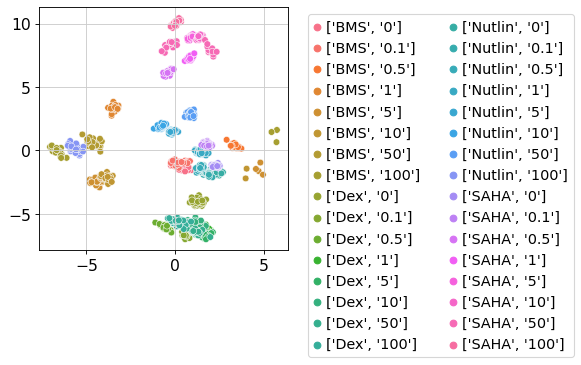

In [13]:
from sklearn.manifold import MDS
mds = MDS(n_components=2, n_jobs=-1, dissimilarity='precomputed')
perturb_embeddings_mds = mds.fit_transform(distance_matrix_sample_200_30)
sns.scatterplot(x=perturb_embeddings_mds[:,0], y=perturb_embeddings_mds[:,1], hue=set_labels_sample_200_30)
plt.legend(bbox_to_anchor=(1.05,1), ncol=2)


In [54]:

D = []
for embedding, label in zip(perturb_embeddings_mds, set_labels_sample_200_30):
    treatment, dose = re.match(".*'(.*)'.*'(.*)'.*", label).groups()
    D.append([float(embedding[0]), float(embedding[1]), treatment, float(dose)])
D = pd.DataFrame(D, columns=['embed_1', 'embed_2', 'treatment', 'dose'])

In [40]:
D.dtypes

embed_1      float64
embed_2      float64
treatment     object
dose         float64
dtype: object

In [56]:
D_one_hot = pd.get_dummies(D)
D_one_hot['embed_1_sq'] = D_one_hot['embed_1'] ** 2
D_one_hot['embed_2_sq'] = D_one_hot['embed_2'] ** 2
D_one_hot['embed_1_cube'] = D_one_hot['embed_1'] ** 3
D_one_hot['embed_2_cube'] = D_one_hot['embed_2'] ** 3

In [58]:
lr = LinearRegression()

X = D_one_hot.loc[:, D_one_hot.columns != 'dose']
y = D_one_hot['dose']
lr.fit(X, y)

LinearRegression()

In [311]:
X

embed_1    embed_2  treatment_BMS  treatment_Dex  treatment_Nutlin  \
0    0.324238  -1.434284              1              0                 0   
1    0.521906  -1.355846              1              0                 0   
2    0.786992  -1.366417              1              0                 0   
3    0.302876  -1.401206              1              0                 0   
4    0.150709  -1.025690              1              0                 0   
..        ...        ...            ...            ...               ...   
955  0.018827  10.042693              0              0                 0   
956  0.027298  10.178808              0              0                 0   
957  0.064336  10.132728              0              0                 0   
958 -0.253087   9.762021              0              0                 0   
959 -0.018266   9.821572              0              0                 0   

     treatment_SAHA  embed_1_sq  embed_2_sq  embed_1_cube  embed_2_cube  
0                 0    0.105130    2.057172      0.034087     -2.950569  
1                 0    0.272386    1.838317      0.142160     -2.492475  
2                 0    0.619356    1.867096      0.487428     -2.551233  
3                 0    0.091734    1.963377      0.027784     -2.751095  
4                 0    0.022713    1.052041      0.003423     -1.079068  
..              ...         ...         ...           ...           ...  
955               1    0.000354  100.855685      0.000007   1012.862690  
956               1    0.000745  103.608138      0.000020   1054.607378  
957               1    0.004139  102.672175      0.000266   1040.349209  
958               1    0.064053   95.297053     -0.016211    930.291828  
959               1    0.000334   96.463286     -0.000006    947.421156  

[960 rows x 10 columns]

In [62]:
logr = LogisticRegression(max_iter=500)
logr.fit(X,y.astype(str))

/home/yavuz/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=500)

In [67]:
np.count_nonzero((logr.predict(X) == y.astype(str)))/ len(y)

0.465625

In [312]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
cross_val_score(XGBClassifier(), X, y.astype(str))

/home/yavuz/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:55:57] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yavuz/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:55:59] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yavuz/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:56:00] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yavuz/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:56:00] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yavuz/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:56:01] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([0.84895833, 0.90104167, 0.89583333, 0.98958333, 0.94791667])

In [70]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
cross_val_score(XGBRegressor(), X, y.astype(str))

array([-9.35900451, -0.80744623, -0.47472732,  0.6123836 , -0.73000787])

In [ ]:
D_cells = []
for cells, label in zip(set_values_sample_200_30, set_labels_sample_200_30):
    treatment, dose = re.match(".*'(.*)'.*'(.*)'.*", label).groups()
    D_cells.append([float(embedding[0]), float(embedding[1]), treatment, float(dose)])
D = pd.DataFrame(D, columns=['embed_1', 'embed_2', 'treatment', 'dose'])

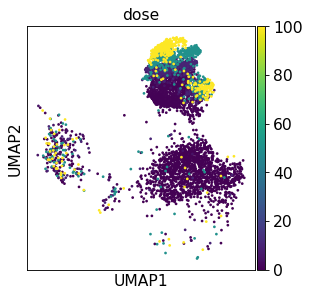

In [73]:
sc.pl.umap(sciplex2[sciplex2.obs.treatment == 'SAHA'], color='dose')

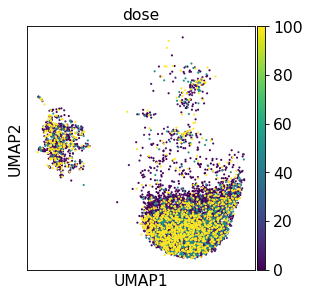

In [76]:
sc.pl.umap(sciplex2[sciplex2.obs.treatment == 'Dex'], color='dose')

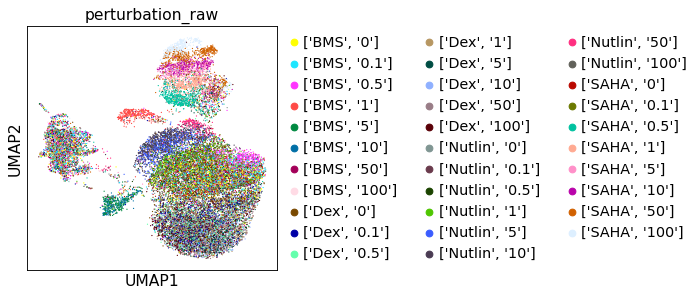

In [88]:
sc.pl.umap(sciplex2, color='perturbation_raw', groups=0.0)

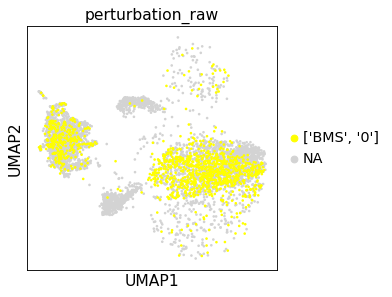

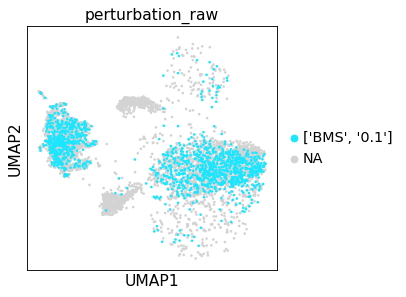

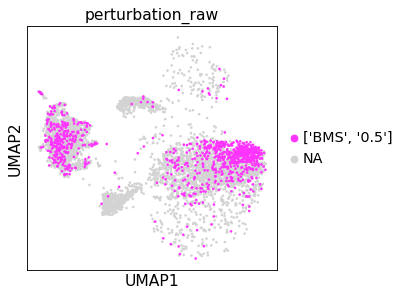

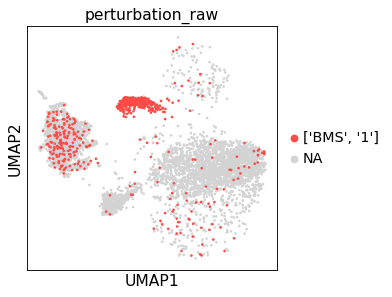

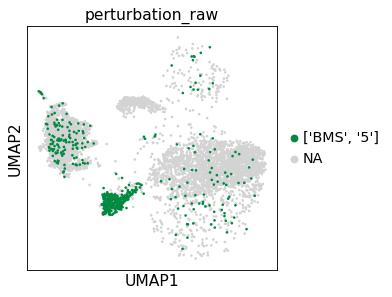

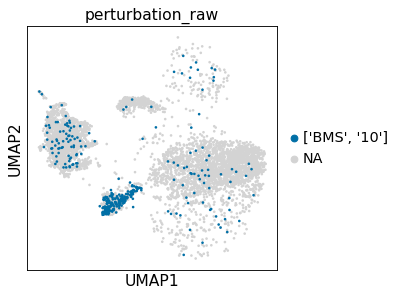

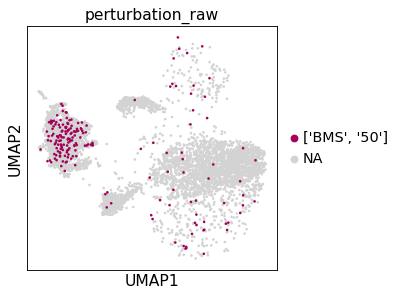

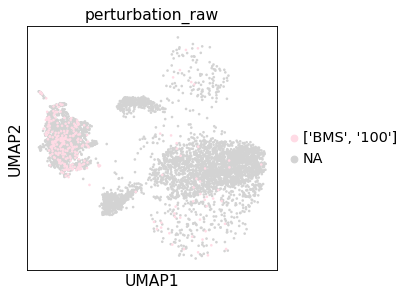

In [108]:
doses = [0,0.1,0.5,1,5,10,50,100]

# fig, ax = plt.subplots(3,3, figsize=(16,16))
for idx, d in enumerate(doses):
#     print(idx)
#     print(idx // 3)
#     print(idx % 3)
# ax=ax[idx // 3][idx % 3]
    sc.pl.umap(sciplex2[(sciplex2.obs.treatment == 'BMS')], color='perturbation_raw', groups=f"['BMS', '{d}']")
    
# fig.show()

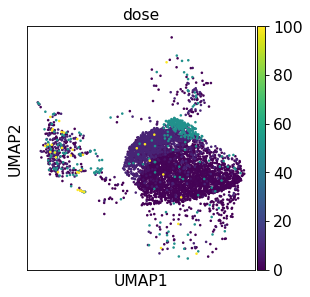

In [78]:
sc.pl.umap(sciplex2[sciplex2.obs.treatment == 'Nutlin'], color='dose')

# Plots for manuscript

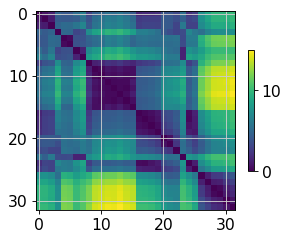

In [192]:
sc.pl.matrix(distance_matrix, save='_full.pdf')

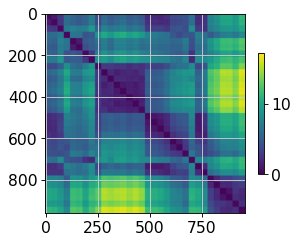

In [191]:
sc.pl.matrix(distance_matrix_sample_200_30, save='_sample_200_30.pdf')

In [221]:
print(sciplex2.obs.groupby(['treatment', 'dose']).size().to_frame(name='value').reset_index(level=1).pivot(columns='dose', values= 'value').to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
dose &  0.0   &  0.1   &  0.5   &  1.0   &  5.0   &  10.0  &  50.0  &  100.0 \\
treatment &        &        &        &        &        &        &        &        \\
\midrule
BMS       &   1193 &   1350 &    943 &    596 &    486 &    333 &    191 &    297 \\
Dex       &    943 &    954 &    853 &   1027 &    986 &    888 &   1137 &   1403 \\
Nutlin    &    975 &    792 &    739 &    848 &    777 &   1074 &    376 &     36 \\
SAHA      &    936 &    736 &    639 &    613 &    460 &    459 &    680 &    469 \\
\bottomrule
\end{tabular}



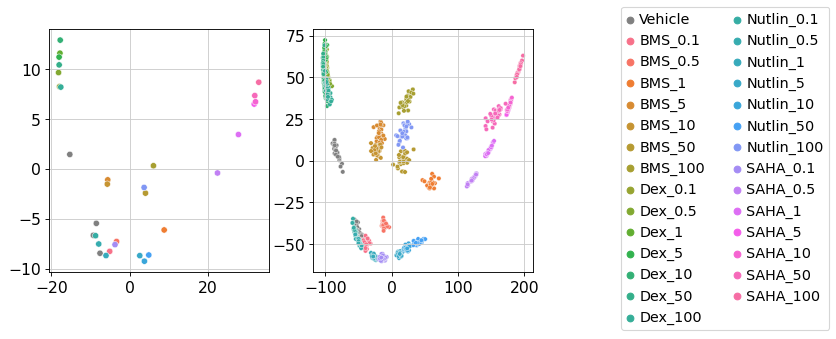

In [352]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

pca = PCA(n_components=2)
perturb_embeddings_pca = pca.fit_transform(distance_matrix)
vehicle_indices = np.array(["'0'" in l for l in set_labels])
labels = np.array(set_labels)
labels[vehicle_indices] = 'Vehicle'

sns.scatterplot(x=perturb_embeddings_pca[vehicle_indices,0], y=perturb_embeddings_pca[vehicle_indices,1], hue=labels[vehicle_indices], palette={'Vehicle': 'gray'}, s=32, ax=ax[0], legend=False)
sns.scatterplot(x=perturb_embeddings_pca[~vehicle_indices,0], y=perturb_embeddings_pca[~vehicle_indices,1], hue=labels[~vehicle_indices], s=32, ax=ax[0], legend=False)

# plt.figure()
# plt.legend(bbox_to_anchor=(1.05,1), ncol=2)
pca = PCA(n_components=2)
perturb_embeddings_pca = pca.fit_transform(distance_matrix_sample_200_30)
vehicle_indices = np.array(["'0'" in l for l in set_labels_sample_200_30])
labels = np.array([ '_'.join(re.match("\['(.*)', '(.*)'\]", l).groups()) for l in set_labels_sample_200_30])
labels[vehicle_indices] = 'Vehicle'

sns.scatterplot(x=perturb_embeddings_pca[vehicle_indices,0], y=perturb_embeddings_pca[vehicle_indices,1], hue=labels[vehicle_indices], palette={'Vehicle': 'gray'}, s=16, ax=ax[1])
sns.scatterplot(x=perturb_embeddings_pca[~vehicle_indices,0], y=perturb_embeddings_pca[~vehicle_indices,1], hue=labels[~vehicle_indices], s=16, ax=ax[1])

# handles, labels = ax[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center')
# handles, labels = ax[0].get_legend_handles_labels()
ax[1].get_legend().remove()
# fig.legend(ncol=2, loc='upper center', 
#                 bbox_to_anchor=(0.5, 1.15), frameon=False)

# fig.legend(ncol=2)
ax[2].remove()
fig.legend(ncol=2)
plt.savefig('figures/sinkhorn_embedding_full_sample_200_30.pdf', dpi=150, bbox_inches='tight')

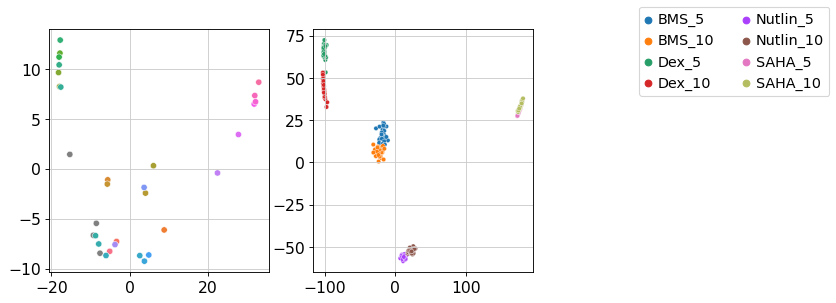

In [500]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

pca = PCA(n_components=2)
perturb_embeddings_pca = pca.fit_transform(distance_matrix)
vehicle_indices = np.array(["'0'" in l for l in set_labels])
labels = np.array(set_labels)
labels[vehicle_indices] = 'Vehicle'

sns.scatterplot(x=perturb_embeddings_pca[vehicle_indices,0], y=perturb_embeddings_pca[vehicle_indices,1], hue=labels[vehicle_indices], palette={'Vehicle': 'gray'}, s=32, ax=ax[0], legend=False)
sns.scatterplot(x=perturb_embeddings_pca[~vehicle_indices,0], y=perturb_embeddings_pca[~vehicle_indices,1], hue=labels[~vehicle_indices], s=32, ax=ax[0], legend=False)

# plt.figure()
# plt.legend(bbox_to_anchor=(1.05,1), ncol=2)
pca = PCA(n_components=2)
perturb_embeddings_pca = pca.fit_transform(distance_matrix_sample_200_30)
vehicle_indices = np.array([ ("'5'" in l or "'10'" in l) for l in set_labels_sample_200_30])
labels = np.array([ '_'.join(re.match("\['(.*)', '(.*)'\]", l).groups()) for l in set_labels_sample_200_30])
# labels[vehicle_indices] = 'Vehicle'

sns.scatterplot(x=perturb_embeddings_pca[vehicle_indices,0], y=perturb_embeddings_pca[vehicle_indices,1], hue=labels[vehicle_indices], s=16, ax=ax[1])
# sns.scatterplot(x=perturb_embeddings_pca[~vehicle_indices,0], y=perturb_embeddings_pca[~vehicle_indices,1], hue=labels[~vehicle_indices], s=16, ax=ax[1])

# handles, labels = ax[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center')
# handles, labels = ax[0].get_legend_handles_labels()
ax[1].get_legend().remove()
# fig.legend(ncol=2, loc='upper center', 
#                 bbox_to_anchor=(0.5, 1.15), frameon=False)

# fig.legend(ncol=2)
ax[2].remove()
fig.legend(ncol=2)
plt.savefig('figures/sinkhorn_embedding_full_sample_200_30.pdf', dpi=150, bbox_inches='tight')

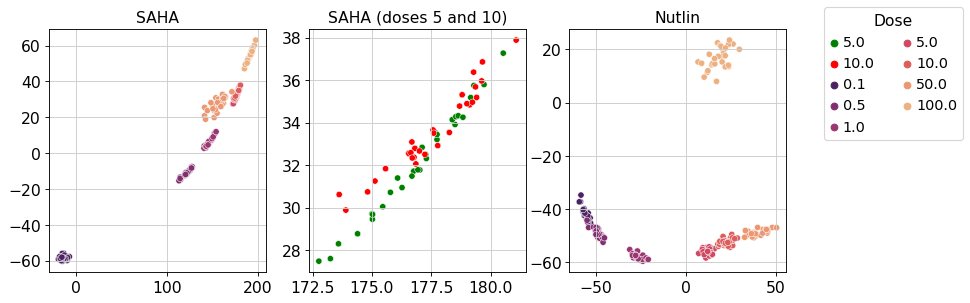

In [544]:
fig, ax = plt.subplots(1,4, figsize=(16,4))

pca = PCA(n_components=2)
perturb_embeddings_pca = pca.fit_transform(distance_matrix_sample_200_30)
norm = colors.LogNorm()

indices = np.array(["'SAHA'" in l and "'0'" not in l for l in set_labels_sample_200_30])
doses = np.array([float(re.match("\['(.*)', '(.*)'\]", l).groups()[1]) for l in set_labels_sample_200_30])
vehicle_indices = indices
sns.scatterplot(x=perturb_embeddings_pca[vehicle_indices,0], y=perturb_embeddings_pca[vehicle_indices,1], hue=doses[vehicle_indices], hue_norm=norm, palette=sns.color_palette("flare_r", as_cmap=True), s=32, ax=ax[0], legend=False)
ax[0].set_title('SAHA')

indices = np.array(["'SAHA'" in l and ("'5'" in l or "'10'" in l) for l in set_labels_sample_200_30])
doses = np.array([float(re.match("\['(.*)', '(.*)'\]", l).groups()[1]) for l in set_labels_sample_200_30])
vehicle_indices = indices
sns.scatterplot(x=perturb_embeddings_pca[vehicle_indices,0], y=perturb_embeddings_pca[vehicle_indices,1], hue=doses[vehicle_indices], palette={5.0 : 'green', 10.0 : 'red' }, s=32, ax=ax[1])
ax[1].set_title('SAHA (doses 5 and 10)')

indices = np.array(["'Nutlin'" in l and "'0'" not in l for l in set_labels_sample_200_30])
doses = np.array([float(re.match("\['(.*)', '(.*)'\]", l).groups()[1]) for l in set_labels_sample_200_30])
vehicle_indices = indices
sns.scatterplot(x=perturb_embeddings_pca[vehicle_indices,0], y=perturb_embeddings_pca[vehicle_indices,1], hue=doses[vehicle_indices], hue_norm=norm, palette=sns.color_palette("flare_r", as_cmap=True), s=32, ax=ax[2], legend='full')
ax[2].set_title('Nutlin')


ax[-3].get_legend().remove()
ax[-2].get_legend().remove()
fig.legend(ncol=2, bbox_to_anchor=(0.9, 1), title='Dose')
ax[-1].remove()
# fig.legend(ncol=2,  bbox_to_anchor=(1.15, 1))
plt.savefig('figures/sinkhorn_embedding_saha_nutlin_dose_coloring.pdf', dpi=150, bbox_inches='tight')

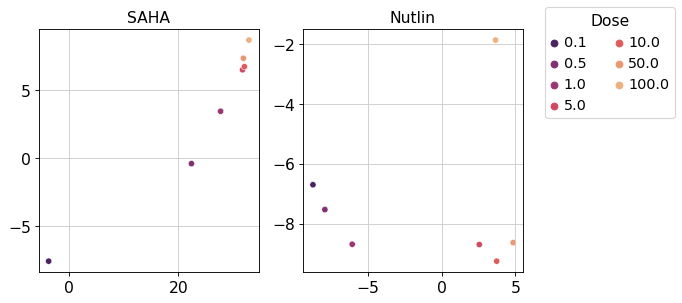

In [396]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

pca = PCA(n_components=2)
perturb_embeddings_pca = pca.fit_transform(distance_matrix)
norm = colors.LogNorm()

indices = np.array(["'SAHA'" in l and "'0'" not in l for l in set_labels])
doses = np.array([float(re.match("\['(.*)', '(.*)'\]", l).groups()[1]) for l in set_labels])
vehicle_indices = indices
sns.scatterplot(x=perturb_embeddings_pca[vehicle_indices,0], y=perturb_embeddings_pca[vehicle_indices,1], hue=doses[vehicle_indices], hue_norm=norm, palette=sns.color_palette("flare_r", as_cmap=True), s=32, ax=ax[0], legend=False)
ax[0].set_title('SAHA')

indices = np.array(["'Nutlin'" in l and "'0'" not in l for l in set_labels])
doses = np.array([float(re.match("\['(.*)', '(.*)'\]", l).groups()[1]) for l in set_labels])
vehicle_indices = indices
sns.scatterplot(x=perturb_embeddings_pca[vehicle_indices,0], y=perturb_embeddings_pca[vehicle_indices,1], hue=doses[vehicle_indices], hue_norm=norm, palette=sns.color_palette("flare_r", as_cmap=True), s=32, ax=ax[1], legend='full')
ax[1].set_title('Nutlin')

ax[1].get_legend().remove()
fig.legend(ncol=2, bbox_to_anchor=(0.85, 1), title='Dose')
ax[2].remove()
# fig.legend(ncol=2,  bbox_to_anchor=(1.15, 1))
plt.savefig('figures/sinkhorn_embedding_saha_nutlin_dose_coloring.pdf', dpi=150, bbox_inches='tight')

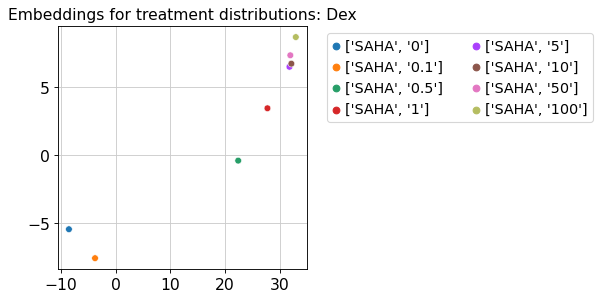

In [346]:
plot_embeddings_from_distance_matrix(distance_matrix=distance_matrix, range_=slice(24,32), labels=set_labels, title='Dex')

## Run classifier

In [560]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
import re
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import MDS

def run_classifier(data, labels, method='pca', classifier='xgboost'):
    if method == 'pca':
        embedder = PCA(n_components=2)
    elif method == 'mds':
        embedder = MDS(n_components=2, n_jobs=-1, dissimilarity='precomputed')
    embeddings = embedder.fit_transform(data)

    D = []
    for embedding, label in zip(embeddings, labels):
        treatment, dose = re.match(".*'(.*)'.*'(.*)'.*", label).groups()
        D.append([float(embedding[0]), float(embedding[1]), treatment, float(dose)])
    D = pd.DataFrame(D, columns=['embed_1', 'embed_2', 'treatment', 'dose'])

    # create prediction dataset
    D_one_hot = pd.get_dummies(D)
    X = D_one_hot.loc[:, D_one_hot.columns != 'dose']
    y = D_one_hot['dose']

    class_labels = y.unique()
    replace_map = {}
    for i, l in enumerate(class_labels):
        replace_map[l] = i
    y = y.replace(replace_map).astype(int)
    if classifier == 'xgboost':        
        y_pred = cross_val_predict(XGBClassifier(use_label_encoder=False), X, y)
        conf_matrix = confusion_matrix(y, y_pred)
        plt.figure(figsize=(8,6))
        map_ = {}
        for t, p in zip(y, y_pred):
            key = (t, p)
            if key in map_:
                map_[key] += 1
            else:
                map_[key] = 1
#         fig, ax = plt.subplots(figsize=(6,6))
        ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=replace_map.keys()).plot(ax=plt.gca(), cmap=plt.cm.Blues)
#         plt.imshow(conf_matrix,)
#         plt.colorbar()
        plt.savefig('figures/xgboost_confusion_matrix.pdf', dpi=150)
        result = cross_validate(XGBClassifier(use_label_encoder=False), X, y, scoring=['f1_weighted', 'precision_weighted', 'recall_weighted'])
        return result
#         return cross_val_score(XGBRegressor(), X, y)


In [418]:
from sklearn.metrics import SCORERS

In [424]:
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

[11:40:06] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:40:07] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:40:08] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:40:08] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:106

{'fit_time': array([0.91501594, 0.7932663 , 0.83007717, 0.88493347, 0.8416574 ]),
 'score_time': array([0.00579453, 0.00558257, 0.00564361, 0.00581431, 0.00562692]),
 'test_f1_weighted': array([0.87714703, 0.80376989, 0.86840728, 0.93766573, 0.87987102]),
 'test_precision_weighted': array([0.88292724, 0.82260604, 0.87049859, 0.94110602, 0.88488266]),
 'test_recall_weighted': array([0.875     , 0.80208333, 0.86979167, 0.9375    , 0.88020833])}

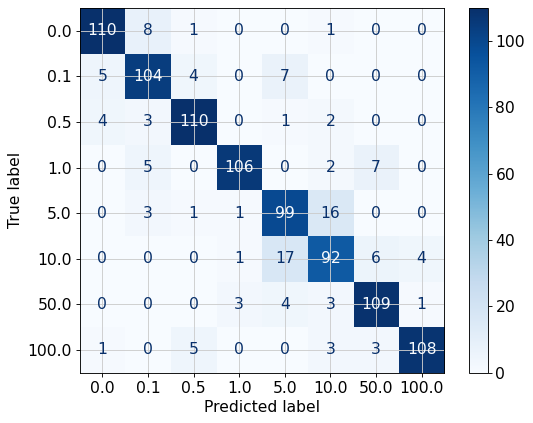

In [561]:
run_classifier(distance_matrix_sample_200_30, set_labels_sample_200_30, method='pca')

In [562]:
np.mean([0.87714703, 0.80376989, 0.86840728, 0.93766573, 0.87987102])

0.8733721899999999

In [483]:
np.mean([0.86160581, 0.82447459, 0.88450246, 0.93250518, 0.8595977])

0.8725371479999999

In [317]:
run_classifier(distance_matrix_sample_200_30, set_labels_sample_200_30, method='pca')

/home/yavuz/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:05:25] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yavuz/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:05:26] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yavuz/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:05:27] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yavuz/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:05:28] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yavuz/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:05:29] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([0.859375  , 0.82291667, 0.88541667, 0.93229167, 0.85416667])

In [315]:
run_classifier(distance_matrix_sample_200_30, set_labels_sample_200_30, method='mds')

/home/yavuz/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:04:42] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yavuz/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:04:43] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yavuz/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:04:44] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yavuz/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:04:45] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yavuz/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:04:46] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([0.88541667, 0.890625  , 0.91666667, 0.94791667, 0.85416667])

In [316]:
run_classifier(distance_matrix_sample_200_30, set_labels_sample_200_30, method='mds')

/home/yavuz/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:05:01] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yavuz/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:05:03] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yavuz/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:05:03] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yavuz/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:05:04] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yavuz/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:05:05] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([0.83854167, 0.92708333, 0.94791667, 0.96354167, 0.94791667])

In [318]:
run_classifier(distance_matrix_sample_200_30, set_labels_sample_200_30, method='mds')

/home/yavuz/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:05:50] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yavuz/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:05:51] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yavuz/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:05:52] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yavuz/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:05:53] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yavuz/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:05:55] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([0.86458333, 0.88541667, 0.90104167, 0.96354167, 0.77083333])